In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings('ignore')


In [2]:

df = pd.read_csv("/Users/suprajamaduryvelagacharla/Downloads/Fraud.csv")
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:

df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [4]:
# Cell 4
# Dropping unuseful columns
df = df.drop(["nameOrig", "nameDest"], axis=1)

# Convert 'type' to numeric using one-hot encoding
df = pd.get_dummies(df, columns=["type"], drop_first=True)

# Checking for duplicates
df.duplicated().sum()


np.int64(543)

In [5]:
df = df.drop_duplicates()
print('duplicates were removed')

duplicates were removed


In [ ]:
### 1. Data Cleaning

- Intially, checking is done for missing values using `isnull().sum()` — fortunately there were none.
- After that, removal of columns like `nameOrig` and `nameDest` because they are just IDs and they do not contribute in prediction


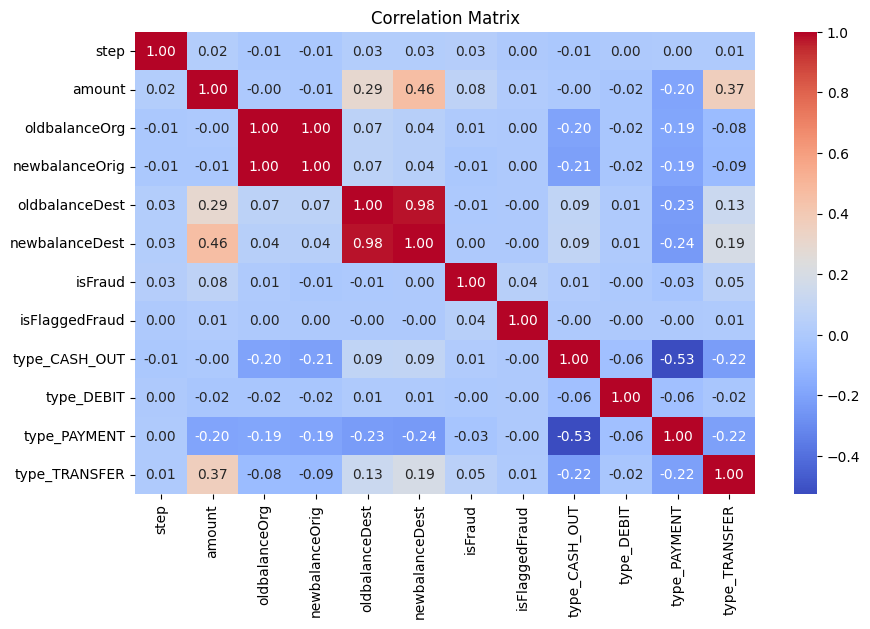

In [6]:

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [ ]:
- Used Heat Map to check the multi collinearity. Here oldbalanceOrg,newbalanceOrig and oldbalanceDest,newbalanceDest are highly correlated.When two features are highly correlated,
one of them should be removed to avoid redundancy.Thus, removing one from each pair here is an important step. 

In [ ]:
# Dropping one form each feature pair with high correlation
df = df.drop(['oldbalanceOrg', 'oldbalanceDest'], axis=1)


In [9]:
#checking whether they are dropped
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6362077 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   amount          float64
 2   newbalanceOrig  float64
 3   newbalanceDest  float64
 4   isFraud         int64  
 5   isFlaggedFraud  int64  
 6   type_CASH_OUT   bool   
 7   type_DEBIT      bool   
 8   type_PAYMENT    bool   
 9   type_TRANSFER   bool   
dtypes: bool(4), float64(3), int64(3)
memory usage: 364.0 MB


In [10]:
# Splitting dataset
X = df.drop("isFraud", axis=1)
y = df["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [11]:
# Training XGBoost model
model = xgb.XGBClassifier(scale_pos_weight=1, use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [12]:
model = xgb.XGBClassifier(scale_pos_weight=1, use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train) 


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
- Used the XG Boost model for the fraud detection, because it handles imabalances data well. Since the fraud data is very imbalanced,
this model helps to catch them better than any other models. And it works by building multiple decision trees improving the performance.
The model handles both numeric and categorical variables and works effectively for classification tasks like fraud detection.

In [13]:
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270777
           1       0.94      0.66      0.77      1639

    accuracy                           1.00   1272416
   macro avg       0.97      0.83      0.89   1272416
weighted avg       1.00      1.00      1.00   1272416

Confusion Matrix:
[[1270711      66]
 [    562    1077]]
ROC AUC Score: 0.8285280279749941


In [ ]:
- The classification report says the performance of the model:
-confusion matrix shows true positives and false negatives
Here,
- Accuracy is 99.96%
- Precision is 0.94 for fraud class=1
- Recall is 0.66 for fraud class=1
- F1-Score is 0.77 for fraud class=1
- ROC AUC Score is 0.83 ( Which means over all very good performance )
As per confusion matrix:
- 1,077 fraudulent transactions were correctly identified.
- 562 frauds were missed.(false negatives).
- Only 66 legitimate transactions were wrongly flagged



In [15]:
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df.sort_values(by="Importance", ascending=False)

,Feature,Importance
5,type_CASH_OUT,0.382528
8,type_TRANSFER,0.175905
2,newbalanceOrig,0.140744
7,type_PAYMENT,0.130079
3,newbalanceDest,0.111329
0,step,0.033902
1,amount,0.025512
4,isFlaggedFraud,0.000000
6,type_DEBIT,0.000000


In [ ]:
-Initially, I included all available features after cleaning.
Then after training the model, checked the feature importances and identified which variables were actually helping the model predict fraud.

Here are the top 3 features that contribute in fraud detection are:
type_CASH_OUT → 38%
type_TRANSFER → 17%
newbalanceOrig → 14%

And the same is represented as Barplot below.


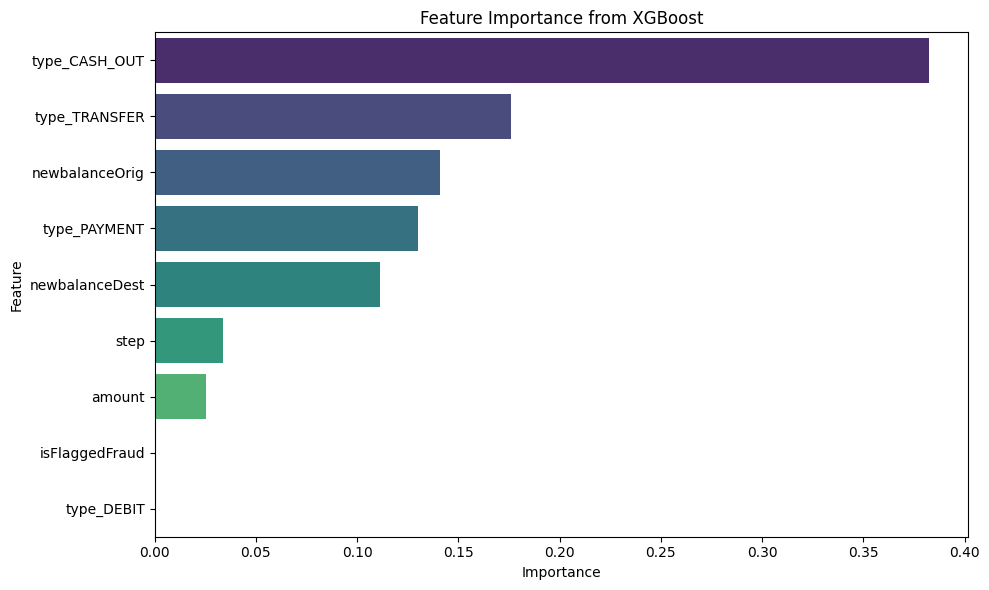

In [16]:
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.sort_values(by="Importance", ascending=False), palette="viridis")
plt.title("Feature Importance from XGBoost")
plt.tight_layout()
plt.show()


In [ ]:
These features make sense because,
- Most of the frauds happen when money is transferred or cashed out.Also, the fradulent transactions involve huge amounts, and strange 
balance changes. The model picks it up well like, if money suddenly vanishes or there's zero balance after large transaction, then it 
suspicious activity, and has the most probability to be fraud.


In [ ]:
prevention should be adopted while company update its infrastructure
- using strong passwords and verification steps.
- Access should only be given to trusted employees.
- Set alerts on large or unusal amounts.
- Transactions should be investigated where the balance goes to zero instantly.
- Updating software and systems often.


In [ ]:
Assuming these actions have been implemented, checking if these actions are working:
- checking fraud rate before and after implemenation of the prevention strategies.
- checking if the model is still giving good results.
- Reviewing system logs to find anything unusual.
- perform audits and penetration testing.
